In [1]:
import flopy
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
model_ws = 'Results'
modelname = 'Ex05'
exe_name = '../Exe/mf6.exe'
sim = flopy.mf6.MFSimulation(sim_name = modelname, exe_name = exe_name, sim_ws = model_ws)

In [3]:
perioddata = [(1.,1,1.)]
nper = len(perioddata)
tdis = flopy.mf6.ModflowTdis(sim, nper = nper,time_units = 'days', perioddata = perioddata)

In [4]:
ims = flopy.mf6.ModflowIms(sim)

In [5]:
gwf = flopy.mf6.ModflowGwf(sim, modelname = modelname, save_flows = True)

In [6]:
#dis
nlay,nrow,ncol = 3,21,20
delr =delc = 500
top = np.ones((nrow,ncol),dtype = np.int32)
for i in range(ncol):
    top[:,i]= 396-i*4

botm = [220,200,0]
dis = flopy.mf6.ModflowGwfdis(gwf,nlay = nlay, nrow = nrow, ncol = ncol,
                          delr = delr, delc = delc, top=top, botm = botm)

In [7]:
ic = flopy.mf6.ModflowGwfic(gwf,strt = 320.)

In [8]:
# Node flow properties

kh = [50,0.01,200]
kv = [10,0.01,20]
icelltype = [1,0,0]
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True,
                             icelltype = icelltype,
                             k=kh, k33 = kv)

In [9]:
# recharge
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.01)

In [10]:
# wells
wel_spd = {0:[[(2,10,9),-150000]]}
wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data = wel_spd)

In [11]:
# riv
riv_spd = {0:[[(0,i,19),320, 1e5,318] for i in range(nrow)]}
riv = flopy.mf6.ModflowGwfriv(gwf,stress_period_data= riv_spd)

In [12]:
# output control
hname = '{}.hds'.format(modelname)
cname = '{}.cbc'.format(modelname)
oc = flopy.mf6.ModflowGwfoc(gwf, budget_filerecord = cname,
                           head_filerecord = hname,
                           saverecord = [('HEAD','ALL'),('BUDGET','ALL')])

In [13]:
# Run

sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model Ex05...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: ../Exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.1.1 06/12/2020

   MODFLOW 6 compiled Jun 11 2020 17:47:19 with IFORT compiler (ver. 19.10.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the softwar

(True, [])

In [14]:
from ipywidgets import interact
fpth = os.path.join(model_ws,modelname+'.hds')
hobj = flopy.utils.HeadFile(fpth)
hds = hobj.get_data()


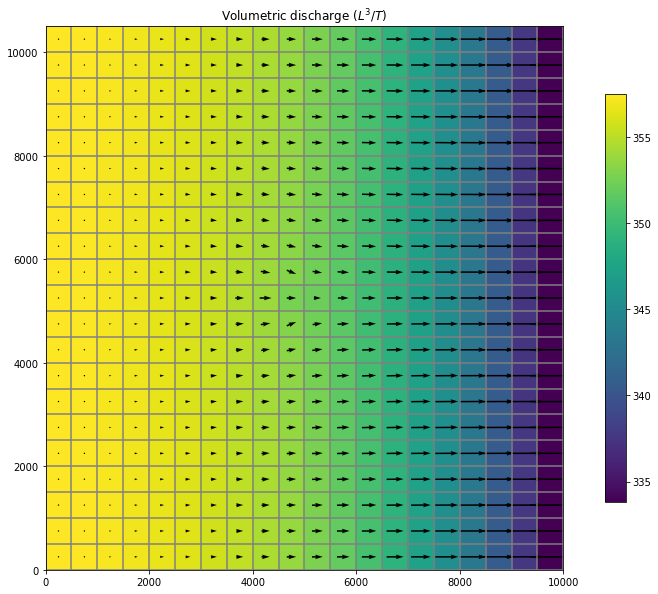

In [15]:
from ipywidgets import interact
fpth = os.path.join(model_ws, modelname+'.hds')
hobj = flopy.utils.HeadFile(fpth)
hds = hobj.get_data()
fpth = os.path.join(model_ws, cname)
cobj = flopy.utils.CellBudgetFile(fpth, precision=hobj.precision)
spd = cobj.get_data(text='DATA-SPDIS')
 
@interact(x=(0,2,1))
def f(x):
    fig = plt.figure(figsize=(15, 10))
 
    ax = fig.add_subplot(1, 1, 1, aspect='equal')
    ax.set_title('Volumetric discharge (' + r'$L^3/T$' + ')')
    mapview = flopy.plot.PlotMapView(model=gwf,layer=x)
    hplot = mapview.plot_array(hds)
    mapview.plot_specific_discharge(spd)
 
    linecollection = mapview.plot_grid()
    plt.colorbar(hplot, shrink=0.75)

In [16]:
mpexe = '../Exe/mpath7.exe'

In [17]:
# particles
partlocs = [(0,i,0) for i in range(nrow)]
particledata = flopy.modpath.ParticleData(partlocs, structured = True)
pg = flopy.modpath.ParticleGroup(particledata = particledata)

In [18]:
mp = flopy.modpath.Modpath7(modelname = modelname+'_mp',
                           model_ws = model_ws, flowmodel = gwf, exe_name = mpexe, headfilename=hname,
                           budgetfilename = cname)
mpbas = flopy.modpath.Modpath7Bas(mp)
mpsim = flopy.modpath.Modpath7Sim(mp, trackingdirection = 'forward',
                                 weaksinkoption = 'pass_through',
                                 weaksourceoption = 'pass_through',
                                 stoptimeoption = 'extend', particlegroups = pg)
mp.write_input()
mp.run_model()

FloPy is using the following  executable to run the model: ../Exe/mpath7.exe

MODPATH Version 7.2.001   
Program compiled Dec 22 2017 11:11:36 with IFORT compiler (ver. 16.0.0)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
        21 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

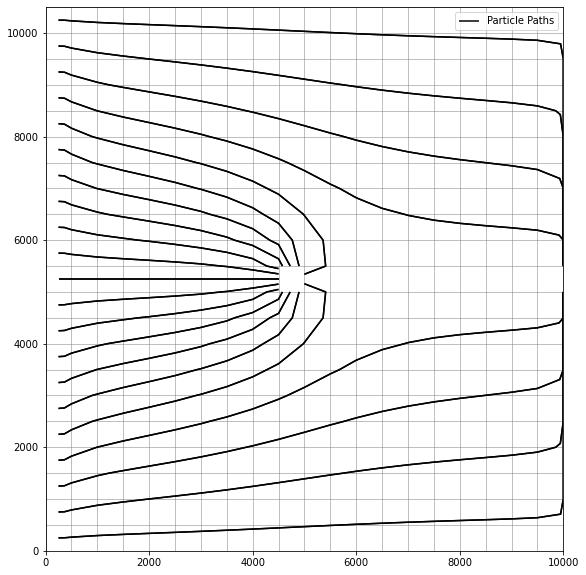

In [19]:
fname = os.path.join(model_ws,modelname+'_mp.mppth')
p = flopy.utils.PathlineFile(fname).get_alldata()
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(1,1,1,aspect = 'equal')
mapview = flopy.plot.PlotMapView(model = gwf,layer =0)
mapview.plot_grid(lw =0.5)
mapview.plot_pathline(p,layer = 'all',colors = 'k', label = 'Particle Paths')
mapview.ax.legend()